In [1]:
import pandas as pd
import numpy as np
from numpy.polynomial import Polynomial as P
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib import cm
#import statsmodels.api as sm
import scipy.stats as stats
import scipy.fft
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import re
from plotters import draw_3d_sensor_heatmap
from skgstat import Variogram, SpaceTimeVariogram
import statsmodels.api as sm

In [2]:
#sb.color_palette("crest", as_cmap=True)

In [2]:
df = pd.read_csv('../data/mergedData.csv')
df.set_index('Timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

sns.set(rc={'figure.figsize':(12,8)})

In [4]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nRow, nCol = df.shape
    colNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{colNames[i]}')
    plt.show()

In [5]:
distanceFromCage = np.array([25, 25, 25, 25, 4, 4, 4, 4, 5, 5, 2, 2, 4, 4, 5, 5, 2, 2, 4, 4, 4, 4])
direction = np.array(['C', 'C','C','C','E','N','W','S','W','W','W','W','W','W','N','N','N','N','S','S','N','W'])
#depth = np.array([int(re.search('m\d+', col).group()[1:]) for col in df.columns])

# Current plots

## Heatmaps

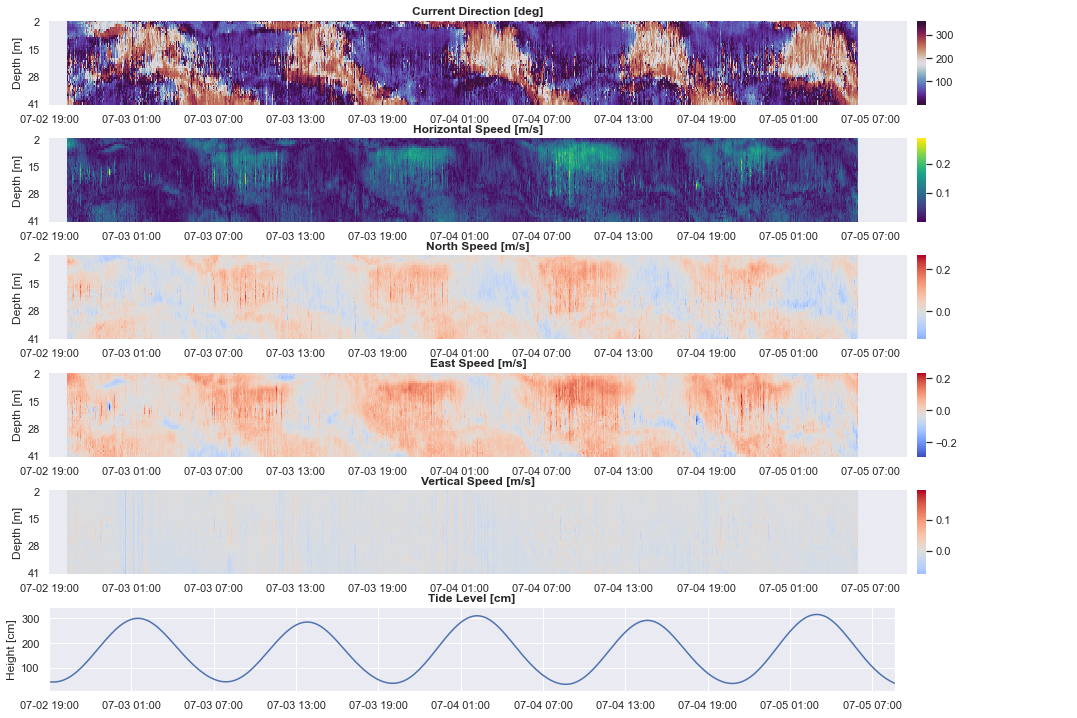

In [6]:
# TODO: Fix axis labels and ticks

timeRange = np.arange(
        '2019-07-02T19:00:00.0000000',
        '2019-07-05T09:40:00.0000000',
        np.timedelta64(360, 'm'),
        dtype='datetime64'
    )

gs = gridspec.GridSpec(nrows=6, ncols=70)

fig, ax = plt.subplots(6,1,figsize=(15,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

ax[0].set_title('Current Direction [deg]', fontweight='bold')
ax[1].set_title('Horizontal Speed [m/s]', fontweight='bold')
ax[2].set_title('North Speed [m/s]', fontweight='bold')
ax[3].set_title('East Speed [m/s]', fontweight='bold')
ax[4].set_title('Vertical Speed [m/s]', fontweight='bold')

cutFrame = df[pd.Timestamp('2019-07-02 19:00:00'):]
cutFrame.index = cutFrame.index.strftime('%m-%d %H:%M')

currentDir = cutFrame.loc[:,'CurrentDirection2m':'CurrentDirection41m'].transpose()
currentDir.index = np.arange(2,42)
currentHori = cutFrame.loc[:,'CurrentHorizontal2m':'CurrentHorizontal41m'].transpose()
currentHori.index = np.arange(2,42)
currentVert = cutFrame.loc[:,'CurrentVertical2m':'CurrentVertical41m'].transpose()
currentVert.index = np.arange(2,42)
currentNorth = cutFrame.loc[:,'CurrentNorth2m':'CurrentNorth41m'].transpose()
currentNorth.index = np.arange(2,42)
currentEast = cutFrame.loc[:,'CurrentEast2m':'CurrentEast41m'].transpose()
currentEast.index = np.arange(2,42)
tideLvl = cutFrame.loc[:,'TideLevel'].dropna().transpose()

yLabels = [2, 15, 28, 41]

p1 = sns.heatmap(currentDir, xticklabels=360, yticklabels = 13, cmap='twilight_shifted', ax=ax[0], cbar_kws=dict(pad=0.01, aspect=10))
p2 = sns.heatmap(currentHori, xticklabels=360, yticklabels = 13, cmap='viridis', ax=ax[1], cbar_kws=dict(pad=0.01, aspect=10))
p3 = sns.heatmap(currentNorth, xticklabels=360, yticklabels = 13, cmap='coolwarm', center = 0.0, ax=ax[2], cbar_kws=dict(pad=0.01, aspect=10))
p4 = sns.heatmap(currentEast, xticklabels=360, yticklabels = 13, cmap='coolwarm', ax=ax[3], cbar_kws=dict(pad=0.01, aspect=10))
p5 = sns.heatmap(currentVert, xticklabels=360, yticklabels = 13, cmap='coolwarm', ax=ax[4], center = 0.00, cbar_kws=dict(pad=0.01, aspect=10))
p1.set_yticklabels(p1.get_yticklabels(), rotation=0)
p2.set_yticklabels(p2.get_yticklabels(), rotation=0)
p3.set_yticklabels(p3.get_yticklabels(), rotation=0)
p4.set_yticklabels(p4.get_yticklabels(), rotation=0)
p5.set_yticklabels(p5.get_yticklabels(), rotation=0)
# TODO fix tide plot
locs, labels = plt.xticks()
ax5 = fig.add_subplot(gs[5,:58])
ax5.set_title('Tide Level [cm]', fontweight='bold')
ax5.plot(tideLvl.index[:-6], tideLvl.values[:-6])
#tideLvl.plot(ax=ax5, x_compat=True)
ax[5].axis("off")
ax5.margins(0.0, 0.1)
start, end = ax5.get_xlim()
ax5.xaxis.set_ticks(np.arange(start, end, 36)) 
ax5.xaxis.label.set_visible(False)
ax5.set_ylabel('Height [cm]')

for axis in ax:
    axis.xaxis.label.set_visible(False)
    axis.set_ylabel('Depth [m]')
    #axis.set_xticklabels(df.index.astype('string')[2::360])
    #axis.yaxis.set_label('Depth')

plt.savefig('currents2')

(2617.0, 2620.0)

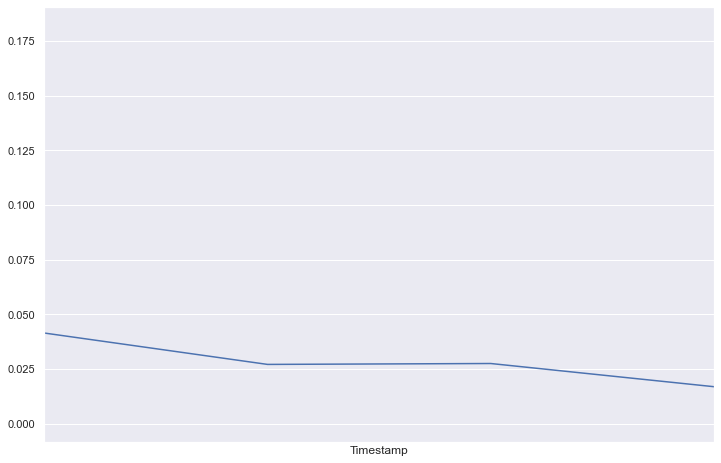

In [7]:
currentHori.iloc[3,:].plot(figsize=(12,8))
plt.xlim(2617,2620)
#currentHori.iloc[1,:].rolling(window = 3, center=True).mean().plot(figsize=(12,8), alpha = 0.5)

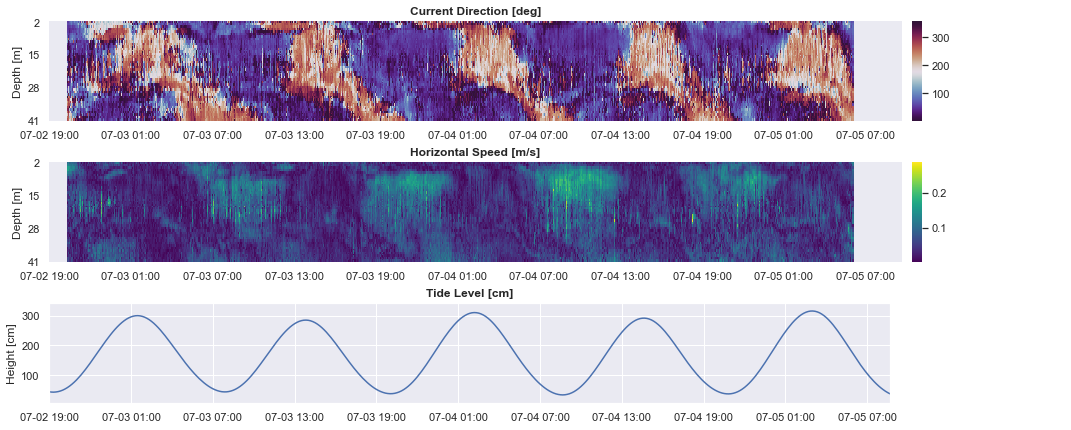

In [8]:
gs = gridspec.GridSpec(nrows=3, ncols=70)

fig, ax = plt.subplots(3,1,figsize=(15,6))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

ax[0].set_title('Current Direction [deg]', fontweight='bold')
ax[1].set_title('Horizontal Speed [m/s]', fontweight='bold')
#ax[2].set_title('North Speed [m/s]', fontweight='bold')
#ax[3].set_title('East Speed [m/s]', fontweight='bold')
#ax[4].set_title('Vertical Speed [m/s]', fontweight='bold')

cutFrame = df[pd.Timestamp('2019-07-02 19:00:00'):]
cutFrame.index = cutFrame.index.strftime('%m-%d %H:%M')

yLabels = [2, 15, 28, 41]

p1 = sns.heatmap(currentDir, xticklabels=360, yticklabels = 13, cmap='twilight_shifted', ax=ax[0], cbar_kws=dict(pad=0.01, aspect=10))
p2 = sns.heatmap(currentHori, xticklabels=360, yticklabels = 13, cmap='viridis', ax=ax[1], cbar_kws=dict(pad=0.01, aspect=10))

p1.set_yticklabels(p1.get_yticklabels(), rotation=0)
p2.set_yticklabels(p2.get_yticklabels(), rotation=0)
#p3.set_yticklabels(p3.get_yticklabels(), rotation=0)
#p4.set_yticklabels(p4.get_yticklabels(), rotation=0)
#p5.set_yticklabels(p5.get_yticklabels(), rotation=0)
# TODO fix tide plot
locs, labels = plt.xticks()
ax5 = fig.add_subplot(gs[2,:58])
ax5.set_title('Tide Level [cm]', fontweight='bold')
ax5.plot(tideLvl.index[:-6], tideLvl.values[:-6])
#tideLvl.plot(ax=ax5, x_compat=True)
ax[2].axis("off")
ax5.margins(0.0, 0.1)
start, end = ax5.get_xlim()
ax5.xaxis.set_ticks(np.arange(start, end, 36)) 
ax5.xaxis.label.set_visible(False)
ax5.set_ylabel('Height [cm]')

for axis in ax:
    axis.xaxis.label.set_visible(False)
    axis.set_ylabel('Depth [m]')
    #axis.set_xticklabels(df.index.astype('string')[2::360])
    #axis.yaxis.set_label('Depth')

plt.savefig('horiDirCurrents2')

C:\Users\moesk\anaconda3\envs\oxygenModel\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\moesk\anaconda3\envs\oxygenModel\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\moesk\anaconda3\envs\oxygenModel\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a 

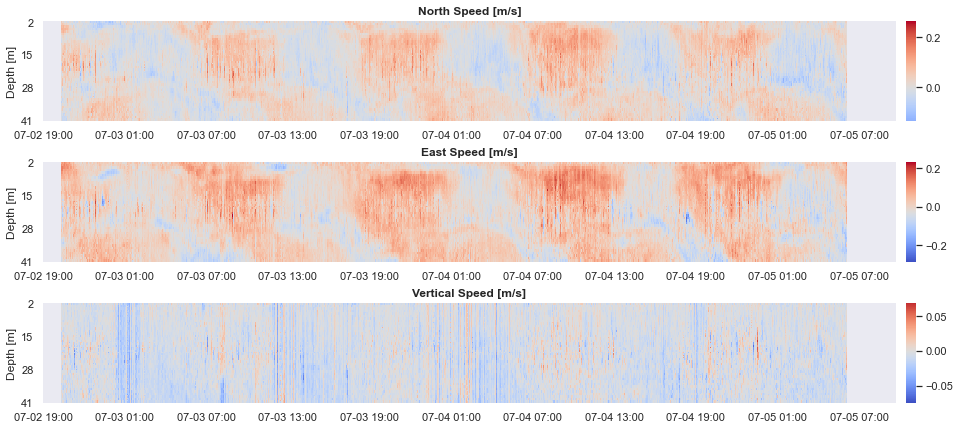

In [9]:
gs = gridspec.GridSpec(nrows=3, ncols=70)

fig, ax = plt.subplots(3,1,figsize=(15,6))
fig.tight_layout()
fig.subplots_adjust(hspace=0.4)

currentVert = cutFrame.loc[:,'CurrentVertical2m':'CurrentVertical41m']
for col in currentVert.columns:
    median = currentVert[col].median()
    currentVert[col] = currentVert[col].mask(currentVert[col] > 0.07, median)
currentVert = currentVert.T
currentVert.index = np.arange(2,42)

#ax[0].set_title('Current Direction [deg]', fontweight='bold')
#ax[1].set_title('Horizontal Speed [m/s]', fontweight='bold')
ax[0].set_title('North Speed [m/s]', fontweight='bold')
ax[1].set_title('East Speed [m/s]', fontweight='bold')
ax[2].set_title('Vertical Speed [m/s]', fontweight='bold')

yLabels = [2, 15, 28, 41]

#p1 = sns.heatmap(currentDir, xticklabels=360, yticklabels = 13, cmap='twilight_shifted', ax=ax[0], cbar_kws=dict(pad=0.01, aspect=10))
#p2 = sns.heatmap(currentHori, xticklabels=360, yticklabels = 13, cmap='viridis', ax=ax[1], cbar_kws=dict(pad=0.01, aspect=10))
p3 = sns.heatmap(currentNorth, xticklabels=360, yticklabels = 13, cmap='coolwarm', center = 0.0, ax=ax[0], cbar_kws=dict(pad=0.01, aspect=10))
p4 = sns.heatmap(currentEast, xticklabels=360, yticklabels = 13, cmap='coolwarm', ax=ax[1], cbar_kws=dict(pad=0.01, aspect=10))
p5 = sns.heatmap(currentVert, xticklabels=360, yticklabels = 13, cmap='coolwarm', ax=ax[2], center = 0.00, cbar_kws=dict(pad=0.01, aspect=10))

#p1.set_yticklabels(p1.get_yticklabels(), rotation=0)
#p2.set_yticklabels(p2.get_yticklabels(), rotation=0)
p3.set_yticklabels(p3.get_yticklabels(), rotation=0)
p4.set_yticklabels(p4.get_yticklabels(), rotation=0)
p5.set_yticklabels(p5.get_yticklabels(), rotation=0)

for axis in ax:
    axis.xaxis.label.set_visible(False)
    axis.set_ylabel('Depth [m]')
    #axis.set_xticklabels(df.index.astype('string')[2::360])
    #axis.yaxis.set_label('Depth')

plt.savefig('NEVcurrents')

<AxesSubplot:xlabel='Timestamp'>

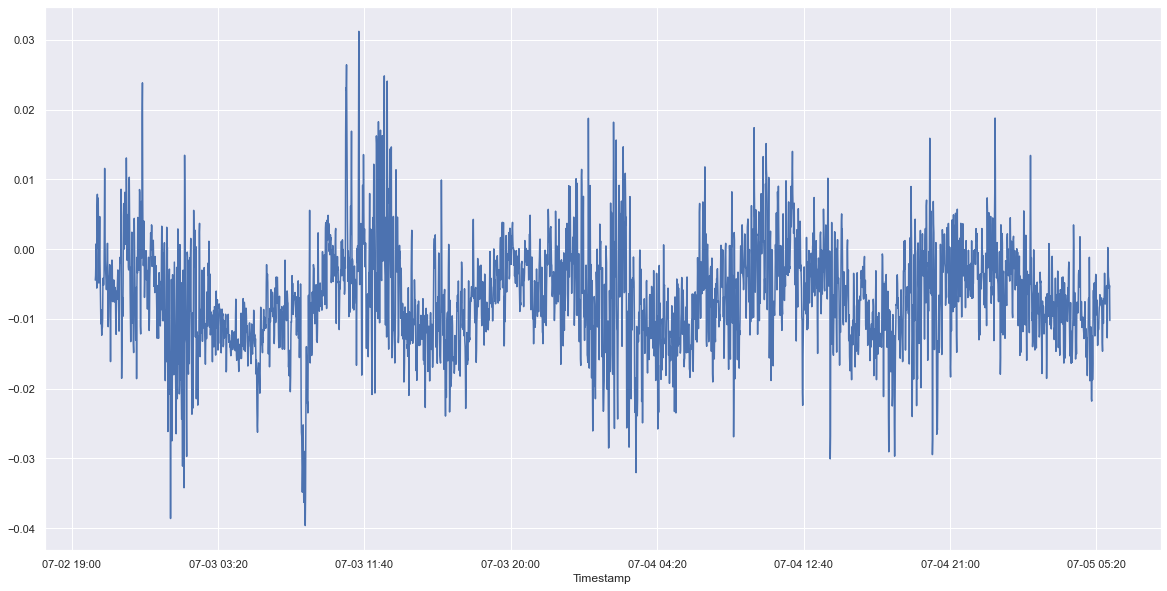

In [10]:
fig = plt.figure(figsize=(20,10))
currentVert.iloc[38].rolling(window = 2, center=True).mean().plot()

In [11]:
#plotPerColumnDistribution(cutFrame.loc[:,'CurrentHorizontal2m':'CurrentHorizontal41m'], 40, 4)

## Center oxygen measurements

### Temperature

<AxesSubplot:xlabel='Timestamp'>

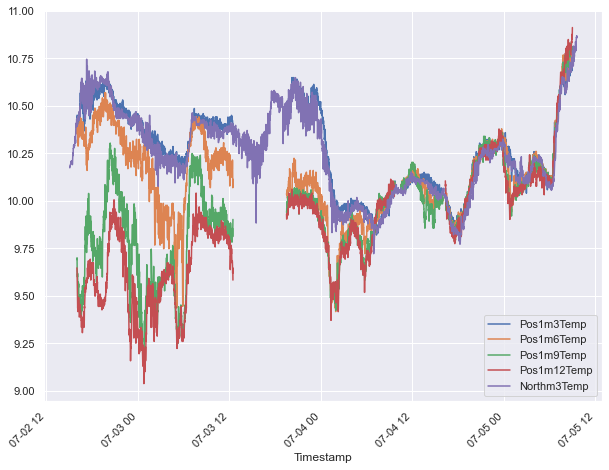

In [12]:
for key, i in enumerate(range(3,13,3)):
    df.loc[:,'Pos1m' + str(i) + 'Temp'].plot(rot = 45, legend=True, figsize=(10,8))
df.loc[:,'Northm3Temp'].plot(rot = 45, legend=True, figsize=(10,8))

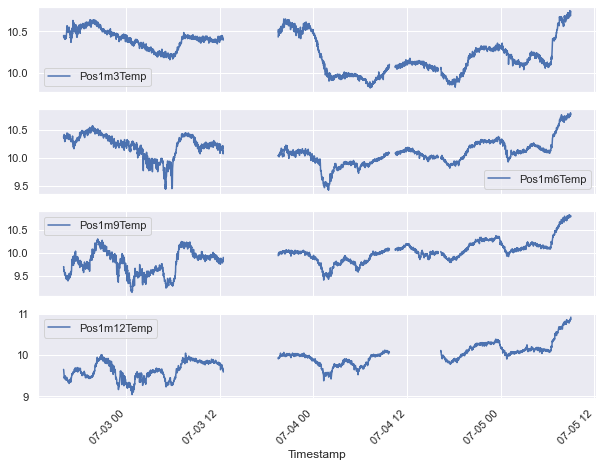

In [13]:
fig, ax = plt.subplots(4,1)
for key, i in enumerate(range(3,13,3)):
    df.loc[:,'Pos1m' + str(i) + 'Temp'].plot(ax=ax[key], rot = 45, legend=True, figsize=(10,8), sharex=True)

### Mean plot

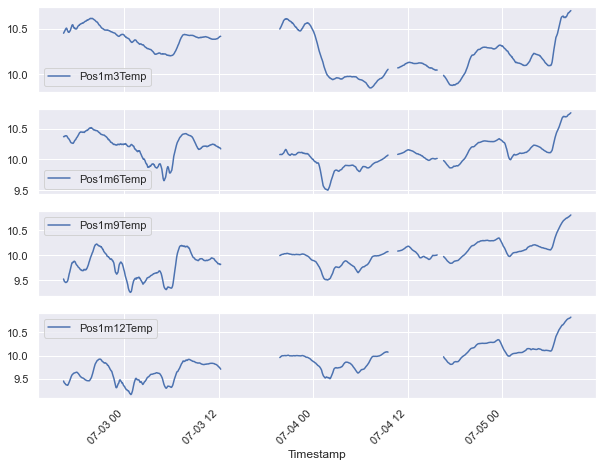

In [14]:
fig, ax = plt.subplots(4,1)
for key, i in enumerate(range(3,13,3)):
    df.loc[:,'Pos1m' + str(i) + 'Temp'].rolling(window = 30, center=True).mean().plot(ax=ax[key], rot = 45, legend=True, figsize=(10,8), sharex=True)
    # .resample('H').mean()

In [15]:
df_do = df[[col for col in df.columns if 'DO' in col]]
direction = np.array(['C', 'C','C','C','E','N','W','S','W','W','W','W','W','W','N','N','N','N','S','S','N','W'])
inside = np.array(['o' if 'Outside' in col else 'i' for col in df_do.columns])
distanceFromCage = np.array([25, 25, 25, 25, 4, 4, 4, 4, 5, 5, 2, 2, 4, 4, 5, 5, 2, 2, 4, 4, 4, 4])
depth = np.array([int(re.search('m\d+', col).group()[1:]) for col in df_do.columns])
newName = np.array(['$'+direction[i]+inside[i]+'^{'+str(distanceFromCage[i])+'}_{'+str(depth[i])+'}$' for i,k in enumerate(df_do.columns)])
#df_do.columns = newName

In [16]:
for i, name in enumerate(newName):
    print(name)

$Ci^{25}_{3}$
$Ci^{25}_{6}$
$Ci^{25}_{9}$
$Ci^{25}_{12}$
$Ei^{4}_{3}$
$Ni^{4}_{3}$
$Wi^{4}_{3}$
$Si^{4}_{3}$
$Wi^{5}_{4}$
$Wi^{5}_{2}$
$Wo^{2}_{2}$
$Wo^{2}_{4}$
$Wi^{4}_{4}$
$Wi^{4}_{2}$
$Ni^{5}_{4}$
$Ni^{5}_{2}$
$No^{2}_{2}$
$No^{2}_{4}$
$So^{4}_{3}$
$Si^{4}_{3}$
$Ni^{4}_{3}$
$Wo^{4}_{3}$


In [17]:
#df_do = df_do.rolling(window = 30, center=True).mean()

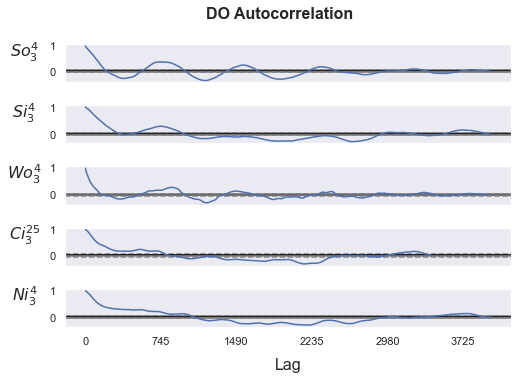

In [18]:
cols = np.array(['SouthOutsidem3DO', 'Southm3DO', 'Outsidem3DO', 'Pos1m3DO', 'Northm3DO'])
fig, ax = plt.subplots(cols.size,1, figsize=(7,5), sharex=True)
fig.suptitle('DO Autocorrelation', fontweight='bold', fontsize=16)
fig.tight_layout()
for i,col in enumerate(cols):
    pd.plotting.autocorrelation_plot(df_do.loc[:,col].dropna(), ax = ax[i])
    colName = newName[df_do.columns.tolist().index(col)]
    ax[i].set_xticks(np.arange(0, df_do.loc[:,col].dropna().size, 745))
    ax[i].set_ylabel(colName, fontweight="bold", rotation = 0, labelpad =25, fontsize = 16)
    ax[i].xaxis.label.set_visible(False)
ax0 = fig.add_subplot(111, frame_on=False)   # creating a single axes
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlabel('Lag', labelpad=30, fontsize = 16)
fig.savefig("DOautocorrelation", bbox_inches = 'tight')

Text(0.5, 0, 'Lag')

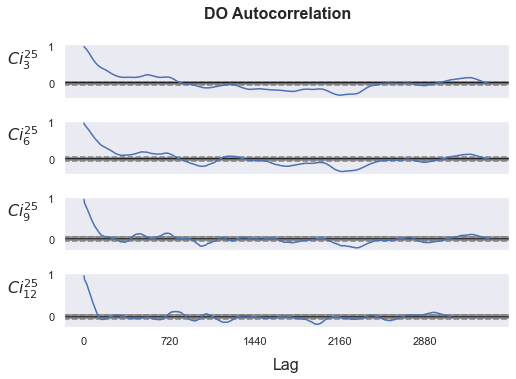

In [19]:
cols = np.array(['Pos1m3DO', 'Pos1m6DO', 'Pos1m9DO', 'Pos1m12DO'])
fig, ax = plt.subplots(cols.size,1, figsize=(7,5), sharex=True)
fig.suptitle('DO Autocorrelation', fontweight='bold', fontsize=16)
fig.tight_layout()
for i,col in enumerate(cols):
    pd.plotting.autocorrelation_plot(df_do.loc[:,col].dropna(), ax = ax[i])
    colName = newName[df_do.columns.tolist().index(col)]
    ax[i].set_xticks(np.arange(0, df_do.loc[:,col].dropna().size, 720))
    ax[i].set_ylabel(colName, fontweight="bold", rotation = 0, labelpad =25, fontsize = 16)
    ax[i].xaxis.label.set_visible(False)
ax0 = fig.add_subplot(111, frame_on=False)   # creating a single axes
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_xlabel('Lag', labelpad=30, fontsize = 16)
#ax0.set_ylabel('Depth', labelpad=30, fontsize = 16)
#fig.savefig("DOautocorrelationCenter", bbox_inches = 'tight')

In [20]:
df_do.columns

Index(['Pos1m3DO', 'Pos1m6DO', 'Pos1m9DO', 'Pos1m12DO', 'Pos4m3DO', 'Pos5m3DO',
       'Pos6m3DO', 'Pos7m3DO', 'Pos21m4DO', 'Pos21m2DO', 'OutsidePos22m2DO',
       'OutsidePos22m4DO', 'Pos23m4DO', 'Pos23m2DO', 'Pos31m4DO', 'Pos31m2DO',
       'OutsidePos32m2DO', 'OutsidePos32m4DO', 'SouthOutsidem3DO', 'Southm3DO',
       'Northm3DO', 'Outsidem3DO'],
      dtype='object')

<AxesSubplot:>

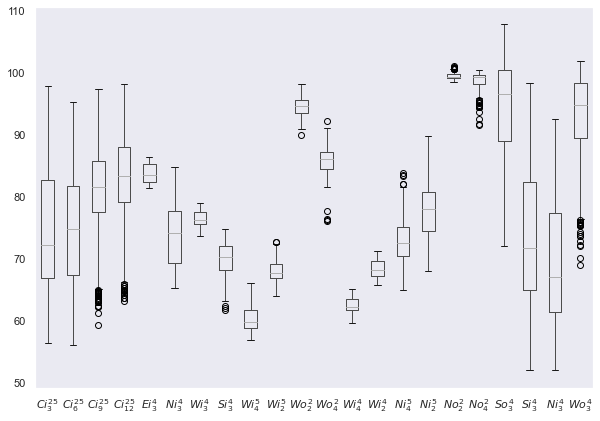

In [21]:
df_do.columns = newName
fig = plt.figure(figsize=(10,7))
df_do.boxplot(grid = False)

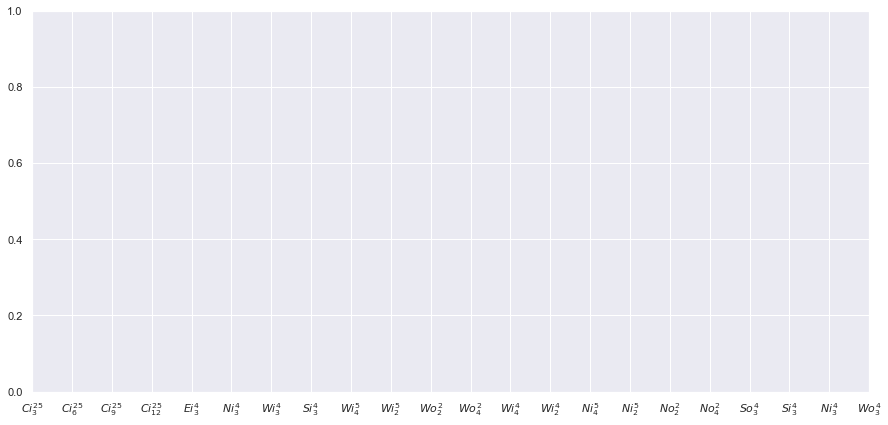

In [22]:
fig, ax = plt.subplots(figsize=(15,7))
sns.set_theme(style = "whitegrid")
#sns.boxplot(data = df_do, ax = ax)
#scaler = StandardScaler()
#scaler = scaler.fit(df_do)
#reg = LinearRegression().fit()
#df_do_st = scaler.transform(df_do)
#depths = np.array([[int(re.search('m\d+', col).group()[1:]) for i in np.arange(0, df_do_st.shape[0])] for col in df_do.columns])
plt.xticks([i for i,k in enumerate(newName)], newName)
plt.show()

df_sorted.columns = ['$W_i', 'Pos23m2DO', 'Pos31m2DO', 'Pos1m3DO', 'Pos4m3DO',
       'Pos5m3DO', 'Pos6m3DO', 'Pos7m3DO', 'Southm3DO', 'Northm3DO',
       'Pos21m4DO', 'Pos23m4DO', 'Pos31m4DO', 'Pos1m6DO', 'Pos1m9DO',
       'Pos1m12DO']

C:\Users\moesk\anaconda3\envs\oxygenModel\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  


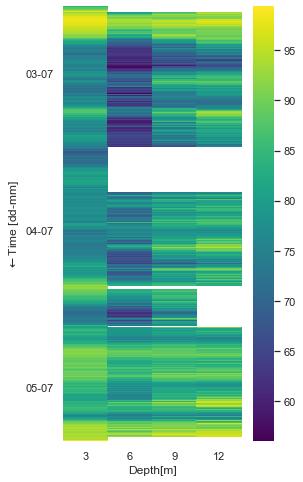

In [23]:
depths = np.array([3,6,9,12])
do_m = np.array([np.nanmean([df[col] for col in df.columns if 'm'+str(i) in col and 'DO' in col],axis=0) for i in depths])
do_m = pd.DataFrame(data = do_m.T, index = df.index.strftime('%d-%m'), columns = depths)
#do_3m.index = do_3m.index.strftime('%d-%m')
plt.figure(figsize = (4,8))
ax = sns.heatmap(do_m, cmap = 'viridis')
ax.set(xlabel='Depth[m]', ylabel=r'$\leftarrow$Time [dd-mm]')
dateLabels = [i.get_text() for i in ax.yaxis.get_ticklabels()]
visible = np.where(np.roll(dateLabels,1)!=dateLabels)[0][1:]
for i, label in enumerate(ax.yaxis.get_ticklabels()):
    if i not in visible:
        label.set_visible(False)
#do_3m.boxplot(figsize = (14,10), grid = False)

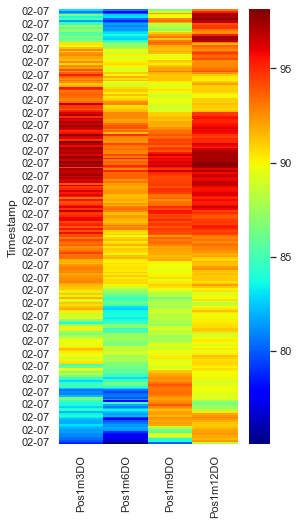

In [24]:
df_center = df[[col for col in df.columns if 'Pos1' in col and 'DO' in col]]
df_center.index = df_center.index.strftime('%d-%m')

plt.figure(figsize = (4,8))
ax = sns.heatmap(df_center[60:300], cmap = 'jet')
#ax.set_yticklabels(df_center.index.strftime('%d-%m-%Y'))

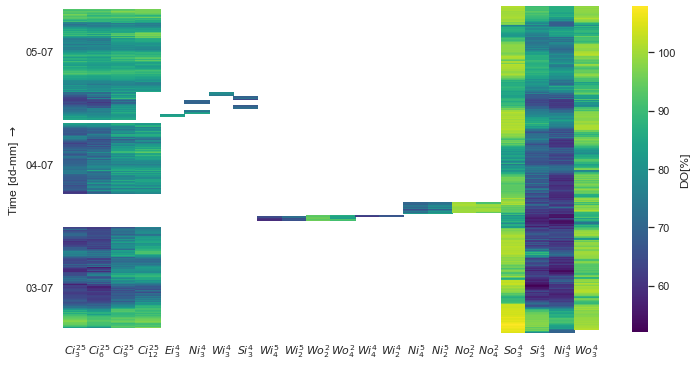

In [25]:
df_a = df_do.copy()
df_a.index = df_a.index.strftime('%d-%m')
plt.figure(figsize = (12,6))
sns.set_style("white")
ax = sns.heatmap(df_a, xticklabels = newName, cmap = 'viridis', cbar_kws={'label':'DO[%]'})
ax.set(ylabel=r'Time [dd-mm] $\rightarrow$')
dateLabels = [i.get_text() for i in ax.yaxis.get_ticklabels()]
visible = np.where(np.roll(dateLabels,1)!=dateLabels)[0][1:]
for i, label in enumerate(ax.yaxis.get_ticklabels()):
    if i not in visible:
        label.set_visible(False)
ax.invert_yaxis()
        
plt.savefig("AllPosHeatmap", bbox_inches = 'tight')
#date_form = DateFormatter("%d-%m")
#ax.yaxis.set_major_formatter(date_form)
#ax.yaxis.set_major_locator(mdates.DayLocator(interval=100))

In [26]:
df_do.columns

Index(['$Ci^{25}_{3}$', '$Ci^{25}_{6}$', '$Ci^{25}_{9}$', '$Ci^{25}_{12}$',
       '$Ei^{4}_{3}$', '$Ni^{4}_{3}$', '$Wi^{4}_{3}$', '$Si^{4}_{3}$',
       '$Wi^{5}_{4}$', '$Wi^{5}_{2}$', '$Wo^{2}_{2}$', '$Wo^{2}_{4}$',
       '$Wi^{4}_{4}$', '$Wi^{4}_{2}$', '$Ni^{5}_{4}$', '$Ni^{5}_{2}$',
       '$No^{2}_{2}$', '$No^{2}_{4}$', '$So^{4}_{3}$', '$Si^{4}_{3}$',
       '$Ni^{4}_{3}$', '$Wo^{4}_{3}$'],
      dtype='object')

<AxesSubplot:xlabel='Timestamp'>

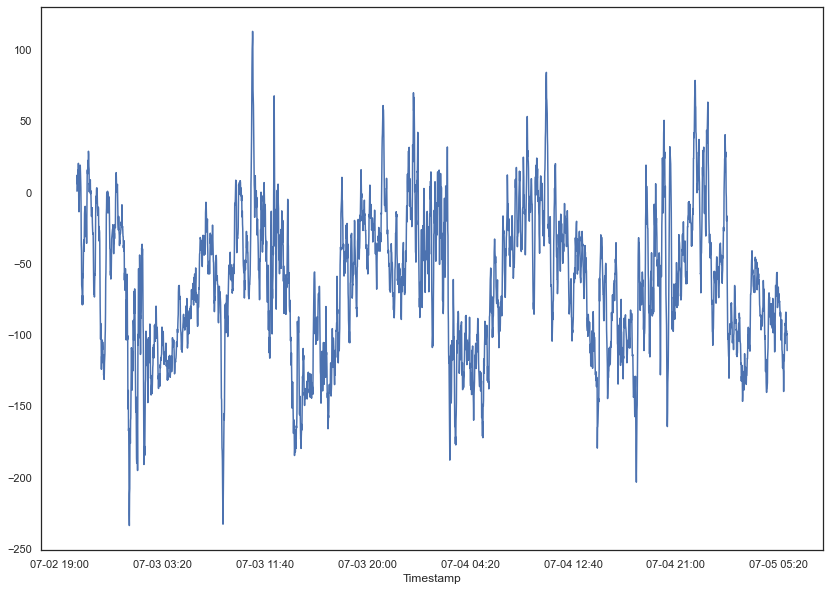

In [27]:
fig = plt.figure(figsize=(14,10))
(10000 * currentVert.iloc[31].rolling(window = 10, center=True).mean()).plot()

<AxesSubplot:xlabel='Timestamp'>

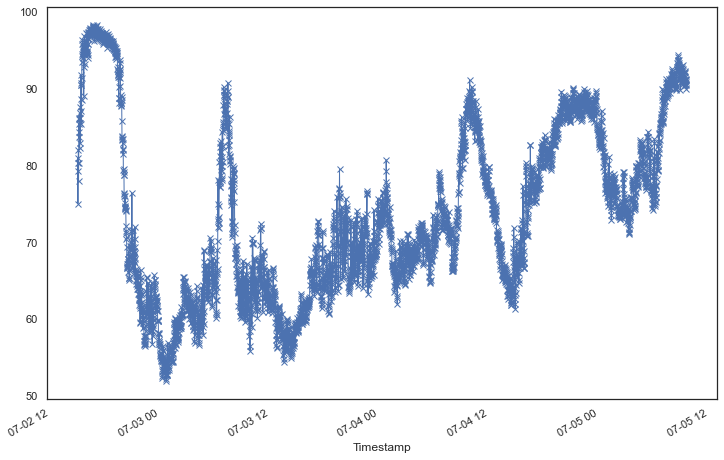

In [28]:
df["Southm3DO"].plot(figsize = (12,8), marker ='x', linewidth =1)

## Fourier Transform

(0.0, 2000.0)

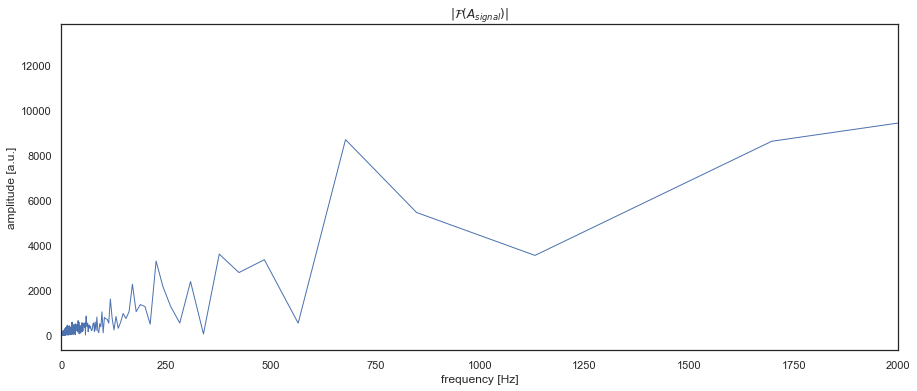

In [29]:
loc = 1
data = df_do.iloc[80:-40,loc].dropna()
fft = abs(scipy.fft.fft(data.sub(data.mean()).values))[1:]
freqs = np.reciprocal(scipy.fft.fftfreq(np.size(data), 1)[1:])
fig=plt.figure(2, figsize=(15,6))
plt.clf()
plt.plot(freqs, np.abs(fft), lw=1.0, c='b')
#plt.stem(freqs, np.abs(fft))
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal})|$")
plt.xlim(0, 2000)
#plt.ylim(0,2000)

(0.0, 4000.0)

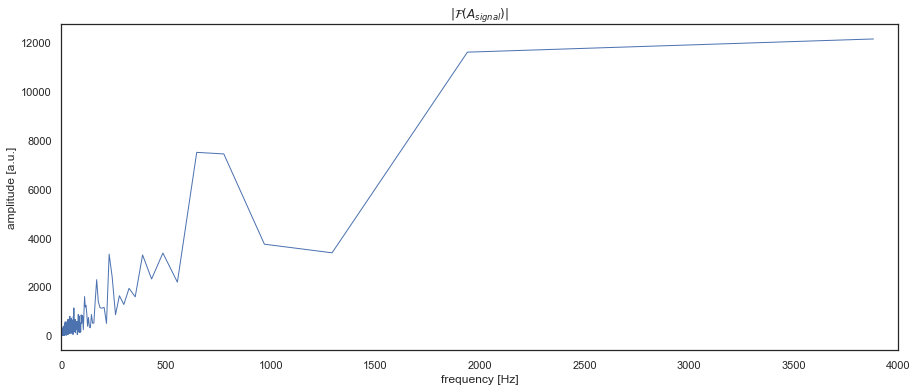

In [30]:
loc = 1
data = df_do.iloc[80:-40,loc].fillna(df_do.iloc[80:-40,loc].mean())
fft = abs(scipy.fft.fft(data.sub(data.mean()).values))[1:]
freqs = np.reciprocal(scipy.fft.fftfreq(np.size(data), 1)[1:])
fig=plt.figure(2, figsize=(15,6))
plt.clf()
plt.plot(freqs, np.abs(fft), lw=1.0, c='b')
#plt.stem(freqs, np.abs(fft))
plt.xlabel("frequency [Hz]")
plt.ylabel("amplitude [a.u.]")
plt.title(r"$|\mathcal{F}(A_{signal})|$")
plt.xlim(0, 4000)

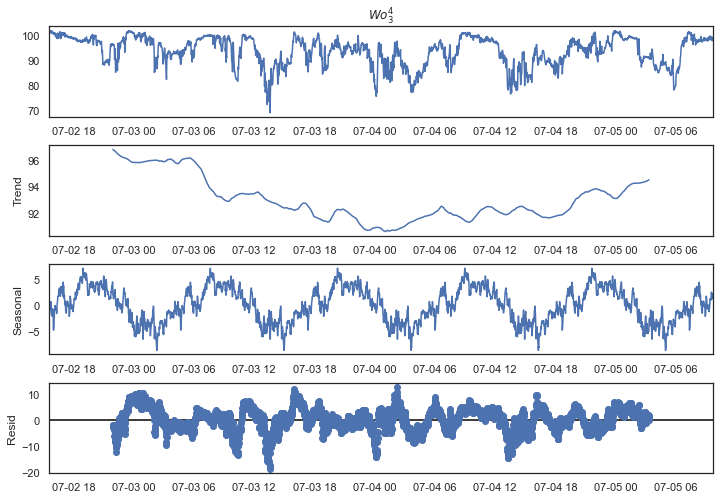

In [31]:
res = sm.tsa.seasonal_decompose(df_do.iloc[:,21].dropna(), model = 'additive', period = 760)
fig = res.plot()
fig.set_figheight(7)
fig.set_figwidth(10)

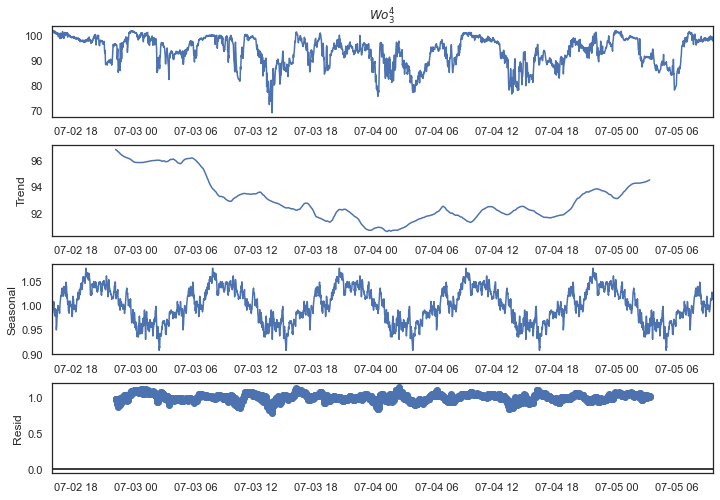

In [32]:
res = sm.tsa.seasonal_decompose(df_do.iloc[:,21].dropna(), model = 'multiplicative', period = 760)
fig = res.plot()
fig.set_figheight(7)
fig.set_figwidth(10)

### Variogram

In [33]:
def empiricalCovMatrix(z, lag):
    cov = 0
    mu = np.nanmean(z, axis = 1)
    for i in np.arange(lag+1, z.shape[1]):
        cov += (z[:,i] - mu)*(z[:,i-lag] - mu).T
    return (1/(z.shape[1] - lag)) * cov

def empiricalSpaceTimeCov(z, lagS, lagT):
    cov = 0
    mu = np.nanmean(z, axis = 1)
    for s in np. arange():
        for t in

SyntaxError: invalid syntax (<ipython-input-33-411a2a3ba847>, line 12)

In [ ]:
y_v[:,1].shape

In [ ]:
empiricalCovMatrix(y_v, 120)

In [ ]:
np.stack((np.arange(y_v.shape[1]), [0] * y_v.shape[1]), axis = 1)

In [ ]:
y_v = df_do.values.T[:,0::1]
#y_v[~np.isnan(y_v)]
#y_v = y_v.T.flatten()

In [ ]:
np.vstack(locations.values)[[0,1,2,3,20,21]]

In [ ]:
Sgram = Variogram(np.vstack(locations.values), np.nanmean(df_do.values.T, axis = 1), model = 'gaussian')
Sgram.rmse
Sgram.plot()

In [ ]:
y_v = y_v = df_do.values.T[[0,1,2,3,19,20],60:280]
Vgram = SpaceTimeVariogram(np.vstack(locations.values)[[0,1,2,3,19,20]], y_v, model= 'sum')

In [ ]:
Vgram.plot('scatter')

### Remove trend with differencing

In [ ]:
fig, ax = plt.subplots(4,1)
for key, i in enumerate(range(3,13,3)):
    df.loc[:,'Pos1m' + str(i) + 'Temp'].diff().plot(ax=ax[key], rot = 45, legend=True, figsize=(10,8), sharex=True)

## Temperature measurements

In [10]:
df_temp = df[[col for col in df.columns if 'Temp' in col]]

In [31]:
df_salInside.iloc[[0],:].T.join(df_salInside.iloc[[0],:].T)

ValueError: columns overlap but no suffix specified: DatetimeIndex(['2019-07-02 16:27:00'], dtype='datetime64[ns]', name='Timestamp', freq=None)

In [28]:
df_tempInside.iloc[[0,:].join(df_salInside.iloc[0,:])

AttributeError: 'numpy.ndarray' object has no attribute 'corr'

In [ ]:
tempColumns = [col for col in df.columns if 'Temp' in col]
positions = []
depths = [1, 2, 3, 4, 6, 9, 12]

fig, axes = plt.subplots(16,len(depths), figsize=(20,18))
fig.tight_layout()

for key, col in enumerate(tempColumns):
    depth = int(re.search('m\d+', col).group()[1:])  # Get sensor depth
    pos = col[0:re.search('m\d+', col).start()]      # Get sensor position

    if pos not in positions:   # Slow, switch to dict later maybe
        positions.append(pos)
    #print(positions.index(pos))
    df.loc[:,col].plot(ax=axes[positions.index(pos), depths.index(depth)], ylim=(8,12))


for key, ax in enumerate(axes[0]):
    ax.set_title(str(depths[key]) + 'm')
    #plt.xticks(rotation=45)
    
for key, ax in enumerate(axes[:,0]):
    ax.set_ylabel(positions[key])
    ax.xaxis.label.set_visible(False)


# TODO: Remove Pos 22 temp measurements?

In [ ]:
df.loc[:,tempColumns].plot(subplots=True, figsize=(12,15), ylim=(8,12))
plt.savefig("temporalPos")

In [ ]:
ax = df.loc[:,tempColumns].diff().plot(subplots=True, figsize=(12,30), linewidth=0.5, sharex=False)
plt.tight_layout()
for axis in ax:
    axis.xaxis.label.set_visible(False)

## Note on Temperature measurement intervals

Moving of sensors cause the temperature to be too high at the start of measurements. This is a problem for positions that were only measured at for a very short time. See position 22 for example.

# DO measurements

In [32]:
df_do = df[[col for col in df.columns if 'DO' in col]]
locations = df_do.iloc[0]
locations = locations.astype('object')
center = 0
for col in locations.index:
    depth = int(re.search('m\d+', col).group()[1:])  # Get sensor depth
    if 'Pos1' in col:
        locations[col] = np.array([center, -depth, center])
    elif 'Pos4' in col:
        locations[col] = np.array([center +21, -depth, center])
    elif 'Pos5' in col:
        locations[col] = np.array([center-2, -depth, center+21])
    elif 'Pos6' in col:
        locations[col] = np.array([center - 20, -depth, center+5])
    elif 'Pos7' in col:
        locations[col] = np.array([center-7, -depth, center-19])
    elif 'Pos12' in col:
        locations[col] = np.array([center, -depth, center])
    elif 'Pos21' in col:
        locations[col] = np.array([center-20, -depth, center+2])
    elif 'Pos22' in col:
        locations[col] = np.array([center-27, -depth, center])
    elif 'Pos23' in col:
        locations[col] = np.array([center-21, -depth, center])
    elif 'Pos31' in col:
        locations[col] = np.array([center + 2, -depth, center + 20])
    elif 'Pos32' in col:
        locations[col] = np.array([center, -depth, center+27])
    elif col == 'Outsidem3DO':
        locations[col] = np.array([center-30, -depth, center])
    elif col =='SouthOutsidem3DO':
        locations[col] = np.array([center, -depth, center -29])
    elif col =='Northm3DO':
        locations[col] = np.array([center, -depth, center+21])
    elif col =='Southm3DO':
        locations[col] = np.array([center, -depth, center-21])

In [ ]:
distanceFromEdge = np.array([(np.linalg.norm(d) - 25) for d in [a[[0,2]] for a in locations.values]]) # Distance from the edges of the cage

In [ ]:
%matplotlib qt
draw_3d_sensor_heatmap(locations.values, df_do.mean())

In [ ]:
%matplotlib inline

In [ ]:
def test(locations, data, compass = True, compassPos = np.array([18, -20, -12.0]), arrowLength = 8):
    """
    Convenience function for plotting a heatmap using sensor positions and data for heatmap.
    Tip: use ""%matplotlib qt" before calling this function to move the 3d plot around
    """
    
    class Arrow3D(FancyArrowPatch):
        def __init__(self, xs, ys, zs, *args, **kwargs):
            FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
            self._verts3d = xs, ys, zs

        def draw(self, renderer):
            xs3d, ys3d, zs3d = self._verts3d
            xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
            self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
            FancyArrowPatch.draw(self, renderer)
    
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111, projection='3d')
    
    distanceFromEdge = np.array([np.linalg.norm(d) - 25 for d in [a[[0,2]] for a in locations]]) # Distance from the edges of the cage
    
    x = np.array([v[0] for v in locations])
    y = np.array([v[2] for v in locations])
    z = np.array([v[1] for v in locations])
    
    cageRadius = 25
    #edgecolors = ['k' if d > 0 else 'none' for d in distanceFromEdge], linewidth = 1.3
    cube = ax.scatter(x, y, z, zdir='z', c=data, cmap="winter", s = 40, edgecolors = ['k' if d > 0 else 'w' for d in distanceFromEdge], linewidth = 1.0, alpha = 1)  # Plot the cube
    #ax.scatter(x, y, z, zdir='z', c=data, cmap="winter")  # Plot the cube
    cbar = fig.colorbar(cube, shrink=0.6, aspect=5)

    # Cylinder for the lice skirt
    center = 0
    us = np.linspace(0, 2 * np.pi, 32)
    zs = np.linspace(0, -10, 2)

    us, zs = np.meshgrid(us, zs)

    xs = cageRadius * np.cos(us)
    ys = cageRadius * np.sin(us)
    
    ax.plot_surface(xs, ys, zs, linewidth = 0, alpha=0.15)
    
    if compass:
        # Draw a compass with needles and directions
        eastArrow = Arrow3D([compassPos[0],compassPos[0] + arrowLength],[compassPos[1],compassPos[1]],[compassPos[2],compassPos[2]], mutation_scale=20, lw=2, arrowstyle="->", color="k")
        northArrow = Arrow3D([compassPos[0],compassPos[0]], [compassPos[1],compassPos[1] + arrowLength], [compassPos[2],compassPos[2]], mutation_scale=20, lw=2, arrowstyle="->", color="b")
        westArrow = Arrow3D([compassPos[0],compassPos[0] - arrowLength],[compassPos[1],compassPos[1]],[compassPos[2],compassPos[2]], mutation_scale=20, lw=2, arrowstyle="->", color="k")
        southArrow = Arrow3D([compassPos[0],compassPos[0]],[compassPos[1],compassPos[1] - arrowLength],[compassPos[2],compassPos[2]], mutation_scale=20, lw=2, arrowstyle="->", color="r")

        ax.add_artist(northArrow)
        ax.add_artist(southArrow)
        ax.add_artist(eastArrow)
        ax.add_artist(westArrow)

        ax.text(compassPos[0] + (arrowLength + 2), compassPos[1], compassPos[2], "E", va = "center", ha = "center")
        ax.text(compassPos[0] - (arrowLength + 2), compassPos[1], compassPos[2], "W", va = "center", ha = "center")
        ax.text(compassPos[0], compassPos[1] + (arrowLength + 2), compassPos[2], "N", va = "center", ha = "center")
        ax.text(compassPos[0], compassPos[1] - (arrowLength + 2), compassPos[2], "S", va = "center", ha = "center")

    # Top edge of the cage
    cage_circle=plt.Circle((center, center), cageRadius, color='black', fill=False, linewidth = 3, alpha = 0.5)
    ax.add_patch(cage_circle)
    art3d.pathpatch_2d_to_3d(cage_circle, z=0, zdir="z")

    ax.set_zlim(-12.5,-1)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")

test(locations.values, df_do.mean())

In [ ]:
distanceFromEdge = np.abs([np.linalg.norm(d) - 25 for d in [a[[0,2]] for a in locations.values]]) # Distance from the edges of the cage
distances = np.array(list(set(distanceFromEdge)))
groupedByDist = np.array([0] * len(distances), dtype = object)
for i,d in enumerate(distances):
    groupedByDist[i] = np.concatenate(df_do[locations.index[distanceFromEdge == d]].values)

plt.scatter(distances[:-1], [np.nanmean(n) for n in groupedByDist][:-1])

In [ ]:
fig, ax = plt.subplots(4,1)
for key, i in enumerate(range(3,13,3)):
    #df.loc[:,col].plot(ax=axes[positions.index(pos), depths.index(depth)], ylim=(50, 110))
    df.loc[:,'Pos1m' + str(i) + 'DO'].plot(ax=ax[key], rot = 45, legend=True, figsize=(10,8), sharex=True, sharey=True)

In [ ]:
DOcolumns = [col for col in df.columns if 'DO' in col]
positions = []
depths = [2, 3, 4, 6, 9, 12]

fig, axes = plt.subplots(14,len(depths), figsize=(20,18))
fig.tight_layout()

for key, col in enumerate(DOcolumns):
    depth = int(re.search('m\d+', col).group()[1:])  # Get sensor depth
    pos = col[0:re.search('m\d+', col).start()]      # Get sensor position

    if pos not in positions:   # Slow, switch to dict later maybe
        positions.append(pos)

    df.loc[:,col].plot(ax=axes[positions.index(pos), depths.index(depth)])


for key, ax in enumerate(axes[0]):
    ax.set_title(str(depths[key]) + 'm')
    #plt.xticks(rotation=45)
    
for key, ax in enumerate(axes[:,0]):
    ax.set_ylabel(positions[key])
    ax.xaxis.label.set_visible(False)

In [ ]:
df.loc[:,DOcolumns].plot(subplots=True, figsize=(12,30))

In [ ]:
ax = df.loc[:,DOcolumns].diff().plot(subplots=True, figsize=(12,30), linewidth=0.5, sharex=False)
#plt.tight_layout()
#plt.xaxis.label.set_visible(False)
plt.suptitle('DO differences')
plt.tight_layout()
plt.subplots_adjust(top=0.97)
for axis in ax:
    axis.xaxis.label.set_visible(False)

In [ ]:
x = mdates.date2num(df.index[df['Southm3DO'].isna() == 0])
coeff = np.polyfit(x,df['Southm3DO'].dropna(), 16)
poly = np.poly1d(coeff)
new_x = np.linspace(x[0], x[-1])
new_y = poly(new_x)

plt.plot(df.index[df['Southm3DO'].isna() == 0], df['Southm3DO'].dropna(), new_x, new_y)

<AxesSubplot:xlabel='Timestamp'>

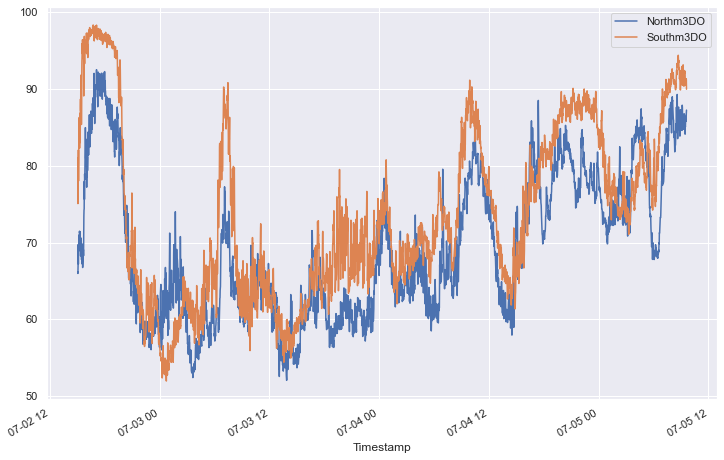

In [35]:
df[["Northm3DO", "Southm3DO"]].plot()

In [67]:
na = 3
init = np.array([0, 3, 0, 1, 2])
I = np.eye(na-1)
A = np.zeros((na,na))
A[:,0] = init[:na]
A[:na-1,1:] = I

In [78]:
B = init[na:]
B[:] = [2]

In [84]:
B = np.array([])
B.shape[0] == 0

True

## Scatter Matrix (Position 1)

In [ ]:
#ax = pd.plotting.scatter_matrix(df.loc[:,tempColumns[:4] + DOcolumns[:4]], figsize=(14,14), alpha= 0.20, diagonal='kde', color = 'tab:blue', edgecolors = 'black')
ax = sns.pairplot(df.loc[:,tempColumns[:4] + DOcolumns[:4]], diag_kind= 'kde', corner=True, kind = "reg")

#for i in range(np.shape(ax)[0]):
    #for j in range(np.shape(ax)[1]):
        #if i < j:
            #ax[i,j].set_visible(False)

In [ ]:
plt.figure(figsize=(14,8))
sns.set_theme(style="white")
corr = df_do.corr()
heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')

In [ ]:
df_do[df_do.columns[1:]].corr()["Pos1m3DO"][:].sort_values(ascending=False).to_frame()

In [ ]:
vals = df_do[["Pos1m3DO", "Pos1m6DO"]].dropna().values
corr, _ = stats.pearsonr(vals[:,0], vals[:,1])

In [ ]:
pd.plotting.autocorrelation_plot(df["TideLevel"].dropna().resample("H").mean())

## DO autocorrelation

In [ ]:
#pd.plotting.autocorrelation_plot(df.loc[:,DOcolumns].dropna())

fig, axes = plt.subplots(14,len(depths), figsize=(20,18))
fig.tight_layout()

for key, col in enumerate(DOcolumns):
    depth = int(re.search('m\d+', col).group()[1:])  # Get sensor depth
    pos = col[0:re.search('m\d+', col).start()]      # Get sensor position

    if pos not in positions:   # Slow, switch to dict later maybe
        positions.append(pos)
    
    ax = pd.plotting.autocorrelation_plot(df.loc[:,col].dropna(), ax=axes[positions.index(pos), depths.index(depth)])
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(np.arange(0, df.loc[:,col].dropna().size, 745))
    #df.loc[:,col].plot(ax=axes[positions.index(pos), depths.index(depth)], ylim=(50, 110))


for key, ax in enumerate(axes[0]):
    ax.set_title(str(depths[key]) + 'm', fontweight="bold")
    ax.xaxis.label.set_visible(False)
    #plt.xticks(rotation=45)
    
for key, ax in enumerate(axes[:,0]):
    ax.set_ylabel(positions[key], fontweight="bold")
    ax.xaxis.label.set_visible(False)

## Temperature autocorrelation

In [ ]:
depths = [1, 2, 3, 4, 6, 9, 12]
fig, axes = plt.subplots(15,len(depths), figsize=(20,18))
fig.tight_layout()

for key, col in enumerate(tempColumns):
    depth = int(re.search('m\d+', col).group()[1:])  # Get sensor depth
    pos = col[0:re.search('m\d+', col).start()]      # Get sensor position

    if pos not in positions:   # Slow, switch to dict later maybe
        positions.append(pos)
    
    ax = pd.plotting.autocorrelation_plot(df.loc[:,col].dropna(), ax=axes[positions.index(pos), depths.index(depth)])
    ax.set_ylabel('')
    ax.set_xlabel('')
    #df.loc[:,col].plot(ax=axes[positions.index(pos), depths.index(depth)], ylim=(50, 110))


for key, ax in enumerate(axes[0]):
    ax.set_title(str(depths[key]) + 'm', fontweight="bold")
    ax.xaxis.label.set_visible(False)
    #plt.xticks(rotation=45)
    
for key, ax in enumerate(axes[:,0]):
    ax.set_ylabel(positions[key], fontweight="bold")
    ax.xaxis.label.set_visible(False)

In [ ]:
fig, ax = plt.subplots(22,1,figsize=(12,30))
for i, col in enumerate(DOcolumns):
    pd.plotting.autocorrelation_plot(df.loc[:,col].dropna(), ax=ax[i])
    ax[i].set_title(col)

plt.suptitle('DO Autocorrelations')
plt.tight_layout()
plt.subplots_adjust(top=0.96)
for axis in ax:
    axis.xaxis.label.set_visible(False)


In [ ]:
pd.plotting.autocorrelation_plot(df['Pos1m3DO'].dropna())

In [ ]:
df.loc[:,DOcolumns[-5]].hist()

In [ ]:
fig = plt.figure(figsize=(8,6))
mu = 0
variance = 2
sigma = np.sqrt(variance)
x = np.linspace(-4, 4, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), lw=3)
for i in np.arange(mu-2*sigma, mu+3*sigma, sigma):
    plt.vlines(mu+i, ymin=0.0, ymax = stats.norm.pdf(i, mu, sigma), color='black', ls='--', lw=2)
plt.xticks([mu+i for i in np.arange(mu-2*sigma, mu+3*sigma, sigma)], ['$\mu - 2\sigma$', '$\mu - \sigma$', '$\mu$', '$\mu + \sigma$', '$\mu - 2\sigma$'], size=15)
plt.ylim(0.0, 0.3)
plt.xlim(-4.0, 4.0)
plt.yticks([])
plt.ylabel('f(x)', size= 15)

# Hide the right and top spines
ax = fig.axes[0]
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

plt.savefig('gaussianDistribution')

In [ ]:
fig, ax = plt.subplots(4,1)
for key, i in enumerate(range(3,13,3)):
    #df.loc[:,col].plot(ax=axes[positions.index(pos), depths.index(depth)], ylim=(50, 110))
    df.loc[:,'Pos1m' + str(i) + 'Temp'].diff().plot(ax=ax[key], rot = 45, legend=True, figsize=(10,8), sharex=True, sharey=True)

## CTD figures for report

In [13]:
df_salInside = df[[col for col in df.columns if 'SalinityInside' in col]].dropna(axis=0, how="all")
df_salOutside = df[[col for col in df.columns if 'SalinityOutside' in col]].dropna(axis=0, how="all")
df_tempInside = df[[col for col in df.columns if 'TempInside' in col]].dropna(axis=0, how="all")
df_tempOutside = df[[col for col in df.columns if 'TempOutside' in col]].dropna(axis=0, how="all")
#df_salDiff = df_salOutside.iloc[]

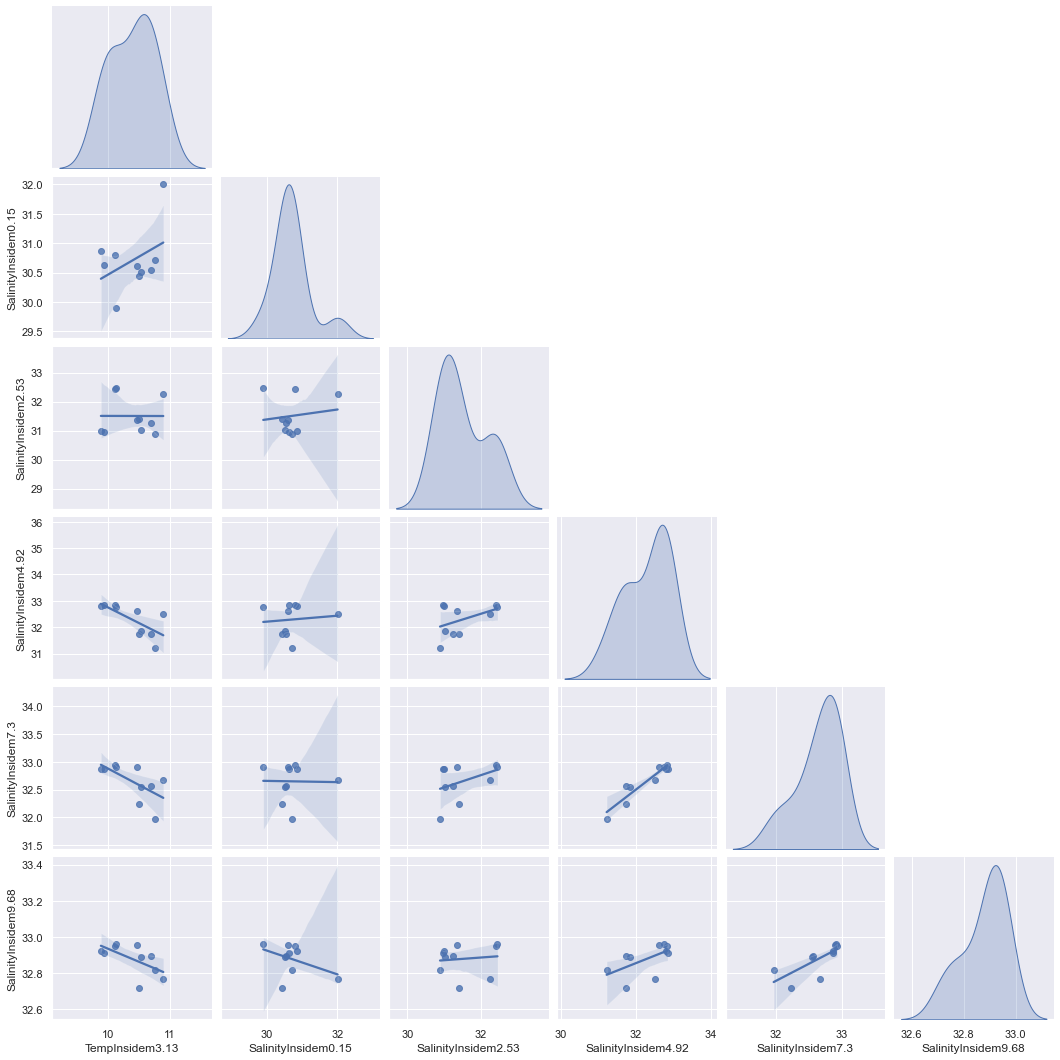

In [72]:
ax = sns.pairplot(df_tempInside.iloc[:,[10]].join(df_salInside.iloc[:,:40:8]), diag_kind= 'kde', corner=True, kind = "reg")

Timestamp
2019-07-02 16:27:00    10.757235
2019-07-03 10:14:00    10.503660
2019-07-03 12:12:00    10.542442
2019-07-03 14:49:00    10.471520
2019-07-03 17:11:00    10.694162
2019-07-04 10:46:00     9.889986
2019-07-04 12:21:00     9.934528
2019-07-04 14:26:00    10.118760
2019-07-04 15:46:00    10.135635
2019-07-05 09:49:00    10.899041
Name: TempInsidem3.13, dtype: float64

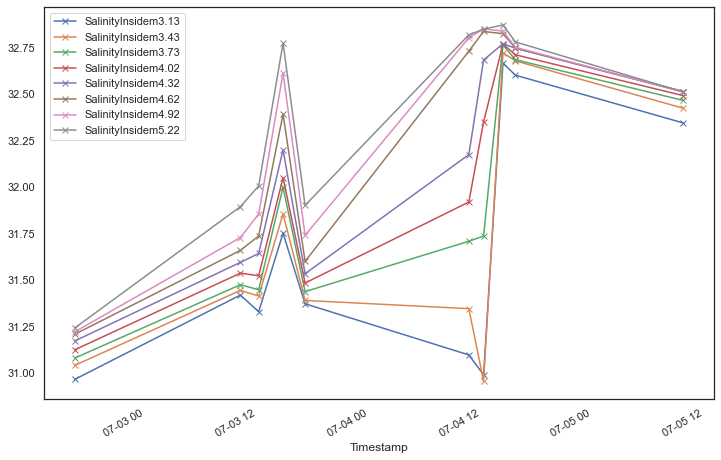

In [41]:
ax = df_salInside.iloc[:,10:18].plot(marker = 'x', legend = True);
#df_salOutside.iloc[:,:10].plot(marker = 'o', legend = False, ax = ax);

In [ ]:
df_salInside.iloc[:,0:40].plot(marker = 'x', legend = False)
#df_salOutside.iloc[5,10:25].plot(marker = 'o')

In [ ]:
for i in np.arange(0, 10):
    df_salOutside.iloc[i,:35].plot(marker = 'x')

In [ ]:
df[["Pos1m3DO"]].diff().plot(marker = 'x')
#df_salInside.iloc[:,11].plot(marker = 'x', secondary_y=True, legend = True)
#df_salOutside.iloc[7,:30].plot(marker = 'o')

In [ ]:
df[["Pos1m12DO"]].diff().iloc[2200:2300].plot(marker = 'x')
df_currH.iloc[:,2].diff().iloc[2200:2300].plot(secondary_y = True, marker = 'o', legend = True)

In [ ]:
#df_salInside.iloc[:,4].plot(marker = "x", legend = False, figsize = (12, 10))
df_do.iloc[:,0].plot(figsize = (12,10), label = "DO", legend = True, color = 'r')
df["CurrentHorizontal6m"].plot(secondary_y = True, label = "CurrentHori", legend = True, linestyle = "--")
#df_salInside.iloc[7,:].plot()
#df_salInside.iloc[9,:].plot()

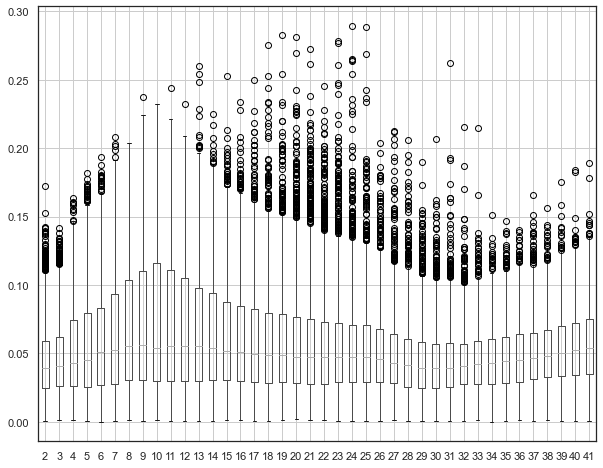

In [35]:
df_currH = df[[col for col in df.columns if 'CurrentHorizontal' in col]]
df_currV = df[[col for col in df.columns if 'CurrentVertical' in col]]
df_currN = df[[col for col in df.columns if 'CurrentNorth' in col]]
df_currE = df[[col for col in df.columns if 'CurrentEast' in col]]

ax = df_currH.boxplot(figsize = (10,8))
ax.set_xticklabels(np.arange(2, df_currH.columns.shape[0]+2));
#df["CurrentHorizontal4m"].plot()
#df["CurrentHorizontal6m"].plot()

In [ ]:
ax = df_currE.diff().boxplot(figsize = (10,8))
ax.set_xticklabels(np.arange(2, df_currE.columns.shape[0]+2));

In [ ]:
ax = df_currH.diff().boxplot(figsize = (12,10))
ax.set_xticklabels(np.arange(2, df_currH.columns.shape[0]+2));

In [ ]:
corr = (df_currH.iloc[:,:20].join(df_do[["Pos1m3DO", "Pos1m9DO"]])).corr()
nlags = 2500
corrs = [(df_currV.iloc[:,:20].rolling(window=20).mean().join(df_do.shift(lag))).corr(method='pearson') for lag in np.arange(0, nlags)]
corrs = [corrs[lag].iloc[:-df_do.shape[1],-df_do.shape[1]:] for lag in np.arange(0, nlags)]
df_corrs = pd.DataFrame([corrs[i].Pos1m3DO for i in np.arange(0,len(corrs))])
#heatmap = sns.heatmap(corr, annot=True, cmap="Blues", fmt='.1g')
#crossCorr =[df_do[["Pos1m3DO"]].corrwith(df_currH.iloc[:,[10]].shift(lag)) for lag in np.arange(0,df_do[["Pos1m3DO"]].shape[0])]

In [ ]:
plt.plot(np.arange(0,nlags), df_corrs);

In [ ]:
corrs = [corrs[lag].iloc[:-df_do.shape[1],-df_do.shape[1]:] for lag in np.arange(0, 2000)]

In [ ]:
df_corrs2 = pd.DataFrame([corrs[i].Southm3DO for i in np.arange(0,len(corrs))])
plt.plot(np.arange(0,1500), df_corrs2.iloc[:,:]);

In [ ]:
df_do.SouthOutsidem3DO.diff().plot()
df_do.SouthOutsidem3DO.plot(secondary_y = True)

In [ ]:
#df_do.SouthOutsidem3DO.iloc[600:700].diff().plot(marker='x')
#df_do.SouthOutsidem3DO.iloc[600:700].plot(marker='o', secondary_y = True)
ax = df.TideLevel.dropna().plot()
#df_do.SouthOutsidem3DO.plot(marker='x')
df_do.Pos1m3DO.diff().plot(marker='x', secondary_y = True)

In [ ]:
df_salInside.columns

In [ ]:
nlags = 2000
corrs = [df[["Pos1m3DO"]].join(df[['SalinityInsidem7.6']].interpolate().shift(lag)).corr() for lag in np.arange(0,nlags)]
df_corrs = pd.DataFrame([corrs[i].Pos1m3DO for i in np.arange(0,len(corrs))]).drop('Pos1m3DO', axis = 1)

<AxesSubplot:xlabel='Timestamp'>

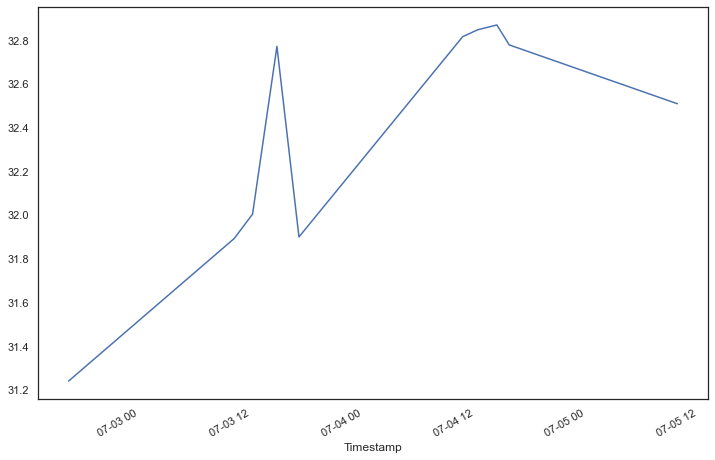

In [39]:
df["SalinityInsidem5.22"].dropna().plot()

In [ ]:
ax = sns.pairplot(df_salInside.iloc[:,30:45:3], diag_kind= 'kde', corner=True, kind = "reg")

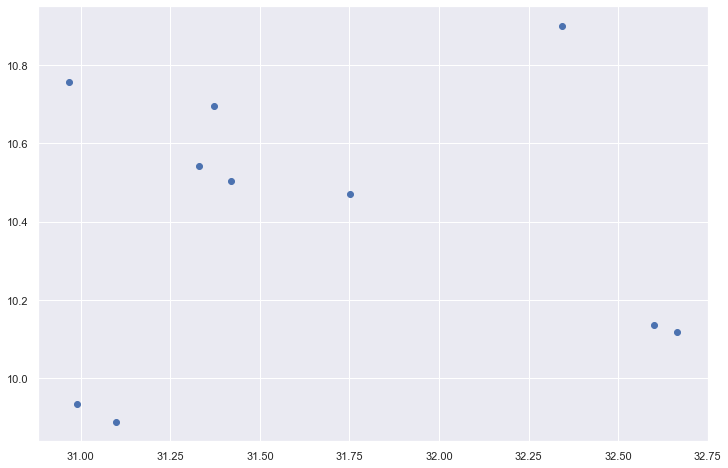